# Language Model para classificação de intenção

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text import *

In [4]:
from pathlib import Path

In [17]:
path = Path('/home/jupyter/hackathon_petrobras')
models_path = Path('/home/jupyter/projeto/modelos')
best_model_path = Path('/home/jupyter/projeto/modelos/bestmodel30k')

In [5]:
df = pd.read_csv('/home/jupyter/hackathon_petrobras/mensagem_entidade.txt', sep=';')

In [6]:
df.head()

,mensagem,intencao
0,quantos Marcos críticos Estão atrasados no ped...,marcos_criticos
1,para novembro quantos são os Marcos críticos p...,marcos_criticos
2,Quais são os Marcos críticos previstos para o ...,marcos_criticos
3,quantos Marcos críticos estão previstos para s...,marcos_criticos
4,quantos Marcos críticos foram realizados pelo ...,marcos_criticos


In [8]:
df.groupby('intencao').count()

,mensagem
intencao,
capex,319
gog,314
marcos_criticos,301
obrigacao,319


In [10]:
#tokenizador
tokenizer = Tokenizer(lang='pt', n_cpus=8)
#vocabulario
with models_path.joinpath('itos.pkl').open('rb') as f:
    itos = pickle.load(f)
vocab = Vocab(itos)

In [11]:
train_bool = np.random.rand(len(df)) < 0.8

In [15]:
data_lm = TextLMDataBunch.from_df(path,
                                  train_df= df[train_bool],
                                  valid_df= df[~train_bool],
                                  tokenizer=tokenizer,
                                  vocab=vocab,
                                  text_cols=0,
                                  bs=24,
                                  max_vocab=35000)

In [16]:
data_lm.save('data_lm')

In [18]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, pretrained_fnames=(best_model_path,models_path.joinpath('itos')))

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


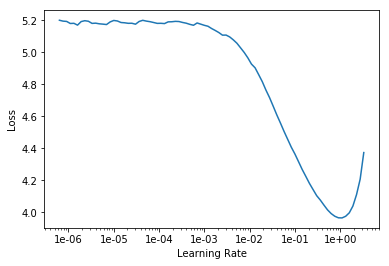

In [20]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(5,  max_lr=slice(2e-1,1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,1.530158,1.787787,0.532143,00:01
1,1.558163,1.824293,0.527381,00:01
2,1.590210,1.802349,0.542560,00:01
3,1.596468,1.771150,0.548214,00:01
4,1.587568,1.740380,0.560714,00:01


In [39]:
learn.save_encoder('pretrained_encoder')

In [26]:
data_clas = TextClasDataBunch.from_df(path,
                                      train_df= df[train_bool],
                                      valid_df= df[~train_bool],
                                      tokenizer=tokenizer,
                                      text_cols=0,
                                      bs=24,
                                      vocab=vocab,
                                      max_vocab=35000,
                                      label_cols=1)

In [27]:
clf = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [40]:
clf.load_encoder('pretrained_encoder')

In [41]:
clf.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.255626,0.195441,0.939130,00:01
1,0.255124,0.221913,0.921739,00:01
2,0.255201,0.204122,0.921739,00:01
3,0.221531,0.179013,0.947826,00:01
4,0.215437,0.186754,0.947826,00:01


In [34]:
pred = clf.predict('como que a capex decorreu no ano de 2019'); pred

(Category capex,
 tensor(0),
 tensor([9.7171e-01, 1.2345e-03, 5.7365e-04, 2.6477e-02]))